Anita Soroush, 98222085, Computational Neuroscience, Project1

In [ ]:
import matplotlib.pyplot as plt    
import numpy as np                 
import time      
import math                 

In [ ]:
def I_creator(type, T, dt, parameters):

    '''
    creates a sequence of values that represents the amount of input current in a form of array.
    
    Expects:
    T          : Total duration of simulation [ms]
    dt         : Simulation time step [ms]
    type       : a string that identifies the input current function
    parameters : a dictionary that contains required parameters of the current function.

    Returns:
    I_array    : an array of distinct values that represents the input current
    '''

    range_T = np.arange(0, T, dt)
    Lt = (range_T).size

    # 1
    if type == "constant":
        I_array = parameters["value"] * np.ones(Lt)


    # 2
    elif type == "sine_wave":
        I_lst = []
        for step in range(Lt):
            # Compute value of t
            t = step * dt

            current_step_I = 400 * (np.sin(t) + 0.9)
            I_lst.append(current_step_I)
        I_array = np.array(I_lst)


    # 3
    elif type == "step_function":
        step_counter = 0
        change_time = parameters["step_times_lst"][0]
        current_current = parameters["currents_lst"][0]

        I_lst = []
        for time_counter in range(Lt):
            # Compute value of t
            t = time_counter * dt
            
            if t > change_time:
                change_time = parameters["step_times_lst"][step_counter]
                current_current = parameters["currents_lst"][step_counter]
                step_counter =  step_counter + 1
            
            current_step_I = current_current
            I_lst.append(current_step_I)

        I_array = np.array(I_lst)


    # 4
    elif type == "linear":
        I_lst = []
        for step in range(Lt):
            # Compute value of t
            t = step * dt

            current_step_I = parameters["constant_multiplier"]*t
            I_lst.append(current_step_I)
        I_array = np.array(I_lst)


    # 5
    elif type == "GWN":
        np.random.seed(seed=parameters['seed']) 

        #generate GWN
        I_array =  parameters['sig'] * np.random.randn(Lt) / np.sqrt(dt/1000.)
        I_array = I_array + 250

        
    return range_T, I_array

In [ ]:
class LIF:
    def __init__(self, V_th, V_reset, tau_m, g_L, V_init, V_L, tref, T, dt):
        ### typical neuron parameters###
        self.V_th = V_th # spike threshold [mV]
        self.V_reset = V_reset #reset potential [mV]
        self.tau_m = tau_m # membrane time constant [ms]
        self.g_L = g_L #leak conductance [nS]
        self.V_init= V_init # initial potential [mV]
        self.V_L = V_L #leak reversal potential [mV]
        self.tref = tref # refractory time (ms)

        ### simulation parameters ###
        self.T = T # Total duration of simulation [ms]
        self.dt = dt  # Simulation time step [ms]
        
        self.range_t = np.arange(0, self.T, self.dt) # Vector of discretized time points [ms]

    def run(self, I):
        '''
        Simulate the LIF dynamics with external input current 
        
        Expects:
        I          : input current [pA]. The injected current should be an array
        
        Returns:
        rec_spikes : spike times
        rec_v      : mebrane potential
        '''

        # Initialize voltage
        Lt = self.range_t.size
        v = np.zeros(Lt)
        v[0] = self.V_init
        tr = 0.


        # simulate the LIF dynamics 
        rec_spikes = []               # record spike times
        for it in range(Lt-1):
            if tr > 0:
                v[it] = self.V_reset
                tr = tr-1

            elif v[it] >= self.V_th:         #reset voltage and record spike event
                rec_spikes.append(it)
                v[it] = self.V_reset
                tr = self.tref/self.dt

            #calculate the increment of the membrane potential
            dv = (
                -(v[it]-self.V_L) 
                + I[it]/self.g_L
                ) * (self.dt/self.tau_m)
            
            #update the membrane potential
            v[it+1] = v[it] + dv
            
        rec_spikes = np.array(rec_spikes) * self.dt
            
        return v, rec_spikes

    def __repr__(self):
        return "This is object of class LIF"

In [ ]:
class AdaptiveLIF:
    def __init__(self, V_th, V_reset, tau_m, g_L, V_init, V_L, tref, T, dt, W_init, a, b):
        ### typical neuron parameters###
        self.V_th = V_th # spike threshold [mV]
        self.V_reset = V_reset #reset potential [mV]
        self.tau_m = tau_m # membrane time constant [ms]
        self.g_L = g_L #leak conductance [nS]
        self.V_init= V_init # initial potential [mV]
        self.V_L = V_L #leak reversal potential [mV]
        self.tref = tref # refractory time (ms)

        self.W_init = W_init #adaption value
        self.a = a 
        self.b = b

        ### simulation parameters ###
        self.T = T # Total duration of simulation [ms]
        self.dt = dt  # Simulation time step [ms]
        
        self.range_t = np.arange(0, self.T, self.dt) # Vector of discretized time points [ms]


    def run(self, I):
        '''
        Simulate the LIF dynamics with external input current 
        
        Expects:
        I          : input current [pA]. The injected current should be an array
        
        Returns:
        rec_spikes : spike times
        rec_v      : mebrane potential
        '''

        # Initialize voltage
        Lt = self.range_t.size
        v = np.zeros(Lt)
        v[0] = self.V_init
        tr = 0.

        # Initialize adaption value
        w = np.zeros(Lt+1)
        w[0] = self.W_init

        # simulate the LIF dynamics 
        rec_spikes = [] # record spike times
        for it in range(Lt-1):

            #calculate the decrement of the adaption value
            dw = (self.a * (v[it]-self.V_L) - w[it]) * (self.dt/self.tau_m)
            
            #update the adaption value
            w[it+1] = w[it] + dw


            if tr > 0:
                v[it] = self.V_reset
                tr = tr-1

            elif v[it] >= self.V_th:  #reset voltage and record spike event and increment of adaption value.
                rec_spikes.append(it)
                v[it] = self.V_reset
                tr = self.tref/self.dt
                w[it+1] = w[it+1] + self.b

            #calculate the increment of the membrane potential
            dv = (
                -(v[it]-self.V_L) 
                + I[it]/self.g_L 
                - w[it+1]/self.g_L
                ) * (self.dt/self.tau_m)
            
            #update the membrane potential
            v[it+1] = v[it] + dv


        rec_spikes = np.array(rec_spikes) * self.dt
            
        return v, rec_spikes


    def __repr__(self):
        return "This is object of class Adaptive LIF"

In [ ]:
class AdaptiveExponentialLIF:
    def __init__(self, V_th, V_reset, tau_m, g_L, V_init, V_L, tref, T, dt, delta_t, W_init, a, b):
        ### typical neuron parameters###
        self.V_th = V_th # spike threshold [mV]
        self.V_reset = V_reset #reset potential [mV]
        self.tau_m = tau_m # membrane time constant [ms]
        self.g_L = g_L #leak conductance [nS]
        self.V_init= V_init # initial potential [mV]
        self.V_L = V_L #leak reversal potential [mV]
        self.tref = tref # refractory time (ms)

        self.delta_t = delta_t
        self.W_init = W_init #adaption value
        self.a = a 
        self.b = b

        ### simulation parameters ###
        self.T = T # Total duration of simulation [ms]
        self.dt = dt  # Simulation time step [ms]
        
        self.range_t = np.arange(0, self.T, self.dt) # Vector of discretized time points [ms]



    def run(self, I):
        '''
        Simulate the LIF dynamics with external input current 
        
        Expects:
        I          : input current [pA]. The injected current should be an array
        
        Returns:
        rec_spikes : spike times
        rec_v      : mebrane potential
        '''

        # Initialize voltage
        Lt = self.range_t.size
        v = np.zeros(Lt)
        v[0] = self.V_init
        tr = 0.

        # Initialize adaption value
        w = np.zeros(Lt+1)
        w[0] = self.W_init

        # simulate the LIF dynamics 
        rec_spikes = []   # record spike times
        for it in range(Lt-1):

            #calculate the decrement of the adaption value
            dw = (self.a * (v[it]-self.V_L) - w[it]) * (self.dt/self.tau_m)
            
            #update the adaption value
            w[it+1] = w[it] + dw


            if tr > 0:
                v[it] = self.V_reset
                tr = tr-1

            elif v[it] >= self.V_th:   #reset voltage and record spike event
                rec_spikes.append(it)
                v[it] = self.V_reset
                tr = self.tref/self.dt
                w[it+1] = w[it+1] + self.b

            #calculate the increment of the membrane potential
            dv = (
                -(v[it]-self.V_L) 
                + self.delta_t*math.exp((v[it] - self.V_th)/self.delta_t) 
                + I[it]/self.g_L 
                - w[it+1]/self.g_L
                ) * (self.dt/self.tau_m)
            
            #update the membrane potential
            v[it+1] = v[it] + dv

        rec_spikes = np.array(rec_spikes) * self.dt
            
        return v, rec_spikes

    def __repr__(self):
        return "This is object of class Adaptive Exponential LIF"

In [ ]:
def membrane_potential_plotter(time_range, voltage):
    plt.plot(time_range, voltage, color = "blue")
    plt.xlim(0, 100)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.show()

In [ ]:
def current_plotter(time_range, current):
    plt.plot(time_range, current , color = "pink")
    plt.xlim(0, 100)
    plt.xlabel('Time (ms)')
    plt.ylabel('Input Current (pA)')
    plt.show()

In [ ]:
def frequency_vs_input_plotter(input_current_lst, frequency_of_spikes_lst):
    plt.plot(input_current_lst, frequency_of_spikes_lst, color = "green")
    plt.xlabel('Input Current (pA)')
    plt.ylabel('Frequency (KHz)')
    plt.show()

In [ ]:
Lif1 = LIF(-55. , -75. , 10. , 10. , -65., -75. , 2. , 400. , .1)

In [ ]:
ALif1 = AdaptiveLIF(-55. , -75. , 10. , 10. , -65., -75. , 2. , 400. , .1, 0, 6, 10)

In [ ]:
AELif1 = AdaptiveExponentialLIF(-55. , -75. , 10. , 10. , -65., -75. , 2. , 400. , .1, 1, 0, 6, 10)

**1) Constant Current:**


In [ ]:
range_T, I_array = I_creator("constant", 400. , .1, {"value":300})

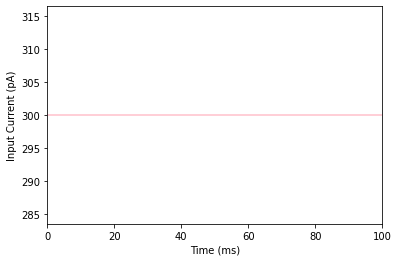

In [ ]:
current_plotter(range_T, I_array)

*   LIF 

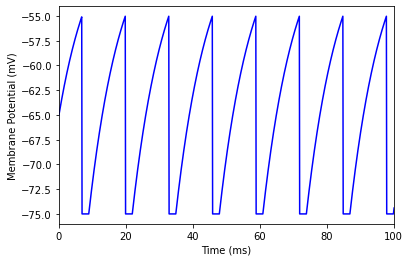

In [ ]:
v, rec_spikes = Lif1.run(I_array)

membrane_potential_plotter(Lif1.range_t, v)

*   Adaptive LIF 

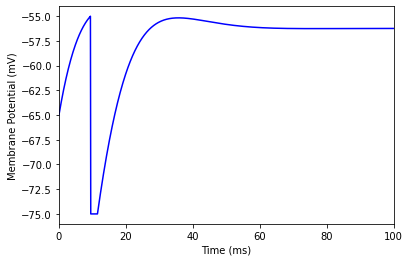

In [ ]:
v, rec_spikes = ALif1.run(I_array)

membrane_potential_plotter(ALif1.range_t, v)

*   Adaptive Exponential LIF 

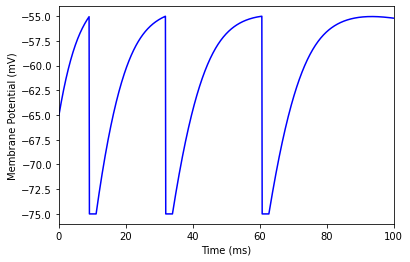

In [ ]:
v, rec_spikes = AELif1.run(I_array)

membrane_potential_plotter(AELif1.range_t, v)

**2) Sine Wave Current:**

In [42]:
range_T, I_array = I_creator("sine_wave", 400. , .1,  {})

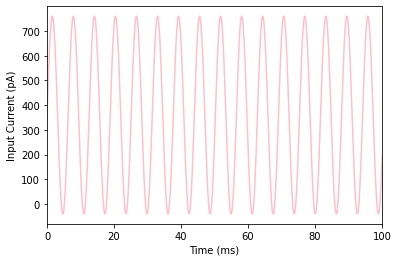

In [43]:
current_plotter(range_T, I_array)

*   LIF 

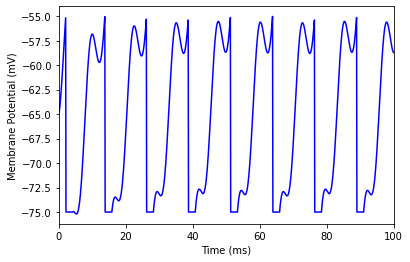

In [44]:
v, rec_spikes = Lif1.run(I_array)

membrane_potential_plotter(Lif1.range_t, v)

*   Adaptive LIF 

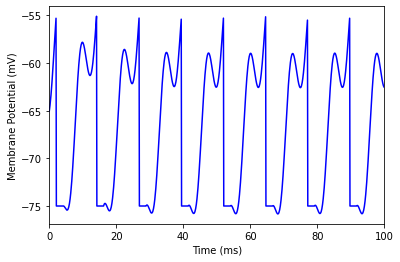

In [45]:
v, rec_spikes = ALif1.run(I_array)

membrane_potential_plotter(ALif1.range_t, v)

*   Adaptive Exponential LIF 

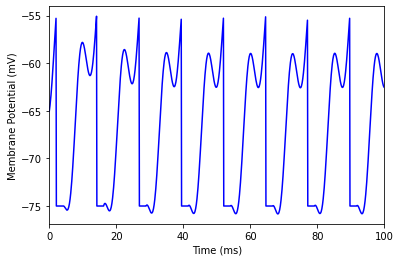

In [46]:
v, rec_spikes = AELif1.run(I_array)

membrane_potential_plotter(AELif1.range_t, v)

**3) Step Function Current:**

In [47]:
step_times_lst = [40, 60, 200, 300, 350, 800]
currents_lst = [100, 150, 400, 490, 520, 600]

range_T, I_array = I_creator("step_function", 400. , .1, {"step_times_lst":step_times_lst, "currents_lst":currents_lst})

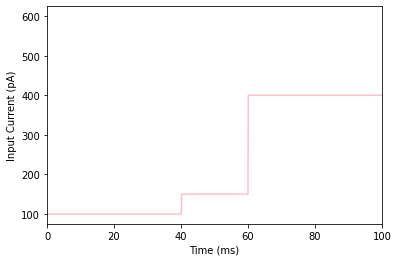

In [48]:
current_plotter(range_T, I_array)

*   LIF 

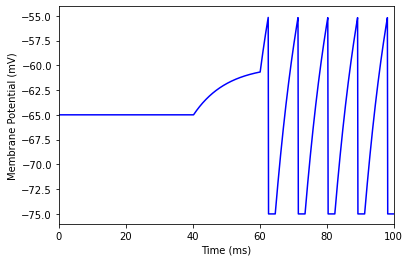

In [49]:
v, rec_spikes = Lif1.run(I_array)

membrane_potential_plotter(Lif1.range_t, v)

*   Adaptive LIF 

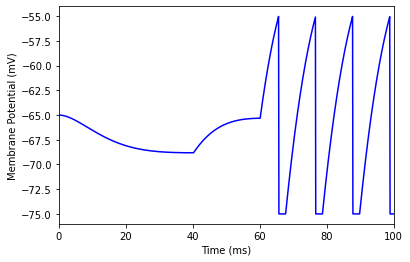

In [50]:
v, rec_spikes = ALif1.run(I_array)

membrane_potential_plotter(ALif1.range_t, v)

*   Adaptive Exponential LIF 

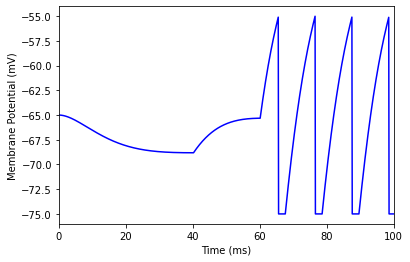

In [51]:
v, rec_spikes = AELif1.run(I_array)

membrane_potential_plotter(AELif1.range_t, v)

**4) Linear Current:**

In [52]:
range_T, I_array = I_creator("linear", 400. , .1, {"constant_multiplier":10})

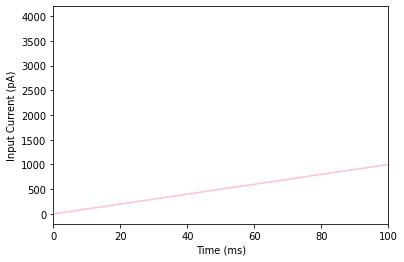

In [53]:
current_plotter(range_T, I_array)

*   LIF 

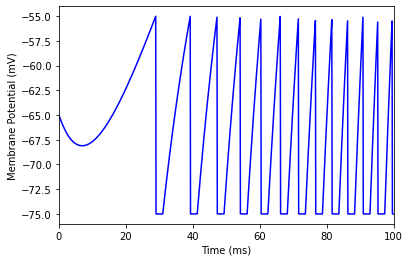

In [54]:
v, rec_spikes = Lif1.run(I_array)

membrane_potential_plotter(Lif1.range_t, v)

*   Adaptive LIF 

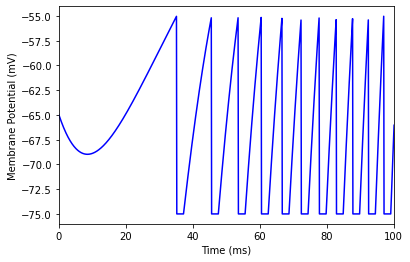

In [55]:
v, rec_spikes = ALif1.run(I_array)

membrane_potential_plotter(ALif1.range_t, v)

*   Adaptive Exponential LIF 

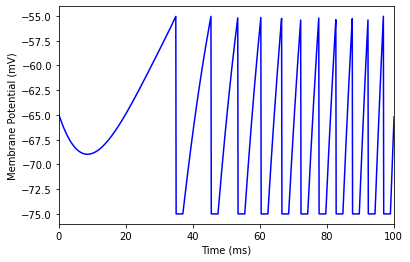

In [56]:
v, rec_spikes = AELif1.run(I_array)

membrane_potential_plotter(AELif1.range_t, v)

**5) Gaussian White Noise Current:**

In [57]:
range_T, I_array = I_creator("GWN", 400. , .1, {"sig":.5, "seed":1998})

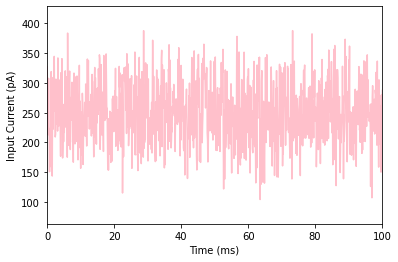

In [58]:
current_plotter(range_T, I_array)

*   LIF 

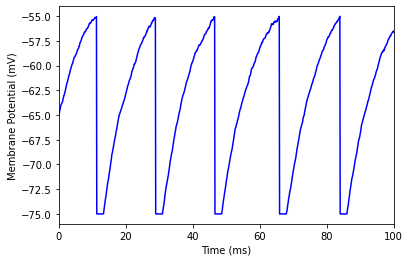

In [59]:
v, rec_spikes = Lif1.run(I_array)

membrane_potential_plotter(Lif1.range_t, v)

*   Adaptive LIF 

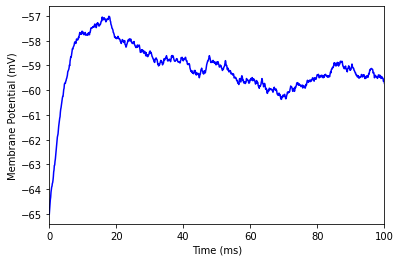

In [60]:
v, rec_spikes = ALif1.run(I_array)

membrane_potential_plotter(ALif1.range_t, v)

*   Adaptive Exponential LIF 

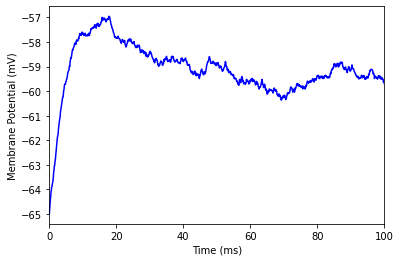

In [61]:
v, rec_spikes = AELif1.run(I_array)

membrane_potential_plotter(AELif1.range_t, v)

This is object of class LIF


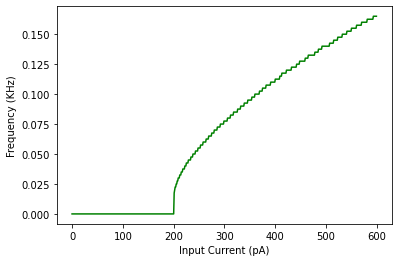

This is object of class Adaptive LIF


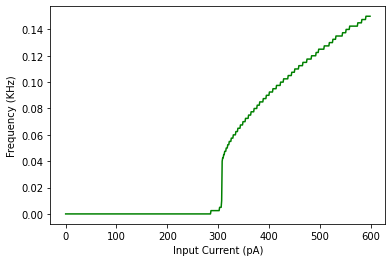

This is object of class Adaptive Exponential LIF


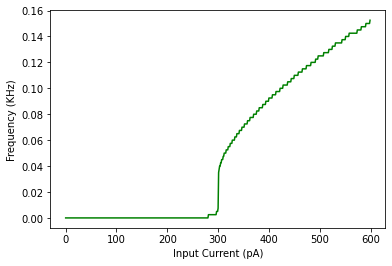

In [62]:
neurons = [Lif1, ALif1, AELif1]

for neuron in neurons:
    print(repr(neuron))
    input_current_lst = []
    frequency_of_spikes_lst = []

    for input_current in range (0, 600):
        input_current_lst.append(input_current)
        range_T, I_array = I_creator("constant", 400. , .1, {"value":input_current})
        rec_spikes = neuron.run(I_array)[1]
        frequency_of_spikes_lst.append(len(rec_spikes)/neuron.T)

    frequency_vs_input_plotter(input_current_lst, frequency_of_spikes_lst)